# Dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds  

from scipy import linalg as la

For loading the dataset, We make use of the tensorflow datasets library. The RGB images were also normalized.

In [2]:
unlabelled, test, train = tfds.load('stl10', split=['unlabelled[:10%]','test','train'], shuffle_files=False, as_supervised=True)
n_images = 10000

images = np.array([np.float32(image)/255 for image, _ in tfds.as_numpy(unlabelled)])
orig_shape = images.shape
print('PCA Set Shape: {0}'.format(images.shape))

x_test = np.array([np.float32(image)/255 for image, _ in tfds.as_numpy(test)])
y_test = np.array([label for _, label in tfds.as_numpy(test)])
print('Test Set Shape: {0}'.format(x_test.shape))

x_train = np.array([np.float32(image)/255 for image, _ in tfds.as_numpy(train)])
y_train = np.array([label for _, label in tfds.as_numpy(train)])
print('Train Set Shape: {0}'.format(x_train.shape))


PCA Set Shape: (10000, 96, 96, 3)
Test Set Shape: (8000, 96, 96, 3)
Train Set Shape: (5000, 96, 96, 3)


The plot_images function creates a plot of 9 sample images arranged in a 3x3 grid. This is used for visualization purposes

In [3]:
def plot_images(images, title, n_images=9):    
    plt.figure(figsize=(10,10))
    plt.suptitle(title, fontsize=20)
    side = int(np.sqrt(n_images))
    for i in range(n_images):
        plt.subplot(side, side, i + 1)
        image = images[i]
        plt.imshow(image)
        plt.axis('off')

    plt.show()
    plt.close('all')

# Part 1. PCA

The STL10_PCA class defines all functions needed to implement PCA for the STL10 dataset.

The init function initializes important variables that will be used multiple times. The initial reshaping and splitting of the images into its channels were also done here.

The normalize function centers the distribution of image pixels to have a mean of 0 and standard deviation of 1. The old and new values for the mean and standard deviation were saved for future use.

The solve_B function does the eigendecomposition of the input and returns the eigenvalues.

The get_projection function solves for the Z-code of the image and computes an initial reconstruction of the image.

The backproject function does the backprojection.

The Z2R function uses the Z-code of X to generate the backprojected image of X.

The load_B function loads the stored eigenvalues for each channel.

The forward function implements the whole PCA algorithm

In [4]:
class STL10_PCA():

    def __init__(self, X):

        X = np.reshape(X,(-1,96*96,3))

        self.X = dict(
            RGB = X,
            Red = X[...,0],
            Green = X[...,1],
            Blue = X[...,2],
        )

        self.B = dict()
        self.use_basis = False
        
        self.Z = dict()
        self.R = dict()

        print('Input Shape: ', X.shape)
        print('Single Channel Shape: ', X[...,0].shape)

    def normalize(self, channel):
        print('Normalizing...')

        mean = np.mean(channel)
        std = np.std(channel)

        channel = (channel - mean) / std

        old = (mean, std)
        new = (np.mean(channel), np.std(channel))

        return channel, old, new

    def solve_B(self, X):
        print('Eigendecomposition...')
        X = np.transpose(X)
        print('X.shape: {0}'.format(X.shape))
        
        S = np.matmul(X, np.transpose(X)) / X.shape[1]
        D,B = la.eig(S,left=True,right=False)
        print('S.shape: {0}'.format(S.shape))
        print('B.shape: {0}'.format(B.shape))

        return B

    def get_projection(self, X, B, M):
        print('Projecting...')
        X = np.transpose(X)

        BM = B[:,:M]
        print('BM.shape: {0}'.format(BM.shape))
        BMT = np.transpose(BM)

        Z = np.matmul(BMT, X)
        
        R = np.matmul(BM,Z)
        R = np.transpose(R)

        return Z, R

    def backproject(self, R, mean, std):

        R *= std
        R += mean
        R = np.float32(np.clip(R, 0, 255))

        return R
    
    def forward(self, M):

        for channel in ['Red', 'Green', 'Blue']:

            print('\n{} channel:'.format(channel))

            X = self.X[channel]
            
            X, old_mu_std, new_mu_std = self.normalize(X)
            print("Before mean: {0}, std: {1}".format(old_mu_std[0],old_mu_std[1]))
            print("After mean: {0}, std: {1}".format(new_mu_std[0],new_mu_std[1]))
            
            if self.use_basis:
                print('Using saved B')
                B = self.B[channel]
            else:
                B = self.solve_B(X)

            Z, R = self.get_projection(X, B, M)

            self.Z[channel] = Z
            self.B[channel] = B
            
            self.R[channel] = self.backproject(R, old_mu_std[0], old_mu_std[1])
        return

    def Z2R(self, Z):

        R = dict()
        M = Z['Red'].shape[0]
        
        for channel in ['Red', 'Green', 'Blue']:

            X = self.X[channel]
            X, old_mu_std, new_mu_std = self.normalize(X)

            B = self.B[channel]
            BM = B[:,:M]
            
            R[channel] = np.matmul(BM,Z[channel])
            R[channel] = np.transpose(R[channel])

            R[channel] = self.backproject(R[channel], old_mu_std[0], old_mu_std[1])

        return R
    
    def load_B(self, file):

        print('Loading B...')
        with np.load(file) as data:
            for channel in ['Red', 'Green', 'Blue']:
                self.B[channel] = data[channel]

        self.use_basis = True


The script below is used to solve for the eigenvalues for each channel using the unlabelled set of STL10.

Uncomment if the npz file has not been generated

In [5]:
# pca_data = STL10_PCA(images)
# pca_data.forward(M=512)
# np.savez_compressed('basis', Red=pca_data.B['Red'], Green=pca_data.B['Green'], Blue=pca_data.B['Blue'])

Input Shape:  (10000, 9216, 3)
Single Channel Shape:  (10000, 9216)
Loading Saved Basis...

Red channel:
Normalizing...
Before mean: 0.43994399905204773, std: 0.26891380548477173
After mean: 2.0622915144485887e-06, std: 1.0000009536743164
B loaded
Projecting...
BM.shape: (9216, 512)


/home/airscan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:67: ComplexWarning: Casting complex values to real discards the imaginary part



Green channel:
Normalizing...
Before mean: 0.4263336658477783, std: 0.2611807882785797
After mean: 1.1772777952501201e-06, std: 0.9999979138374329
B loaded
Projecting...
BM.shape: (9216, 512)

Blue channel:
Normalizing...
Before mean: 0.3843904137611389, std: 0.2677249312400818
After mean: 4.054468263348099e-06, std: 1.000001072883606
B loaded
Projecting...
BM.shape: (9216, 512)


The script below solves for the reconstruction of the test set for varying values of M and its respective mse against the original test images. It also shows sample reconstructions for each M.

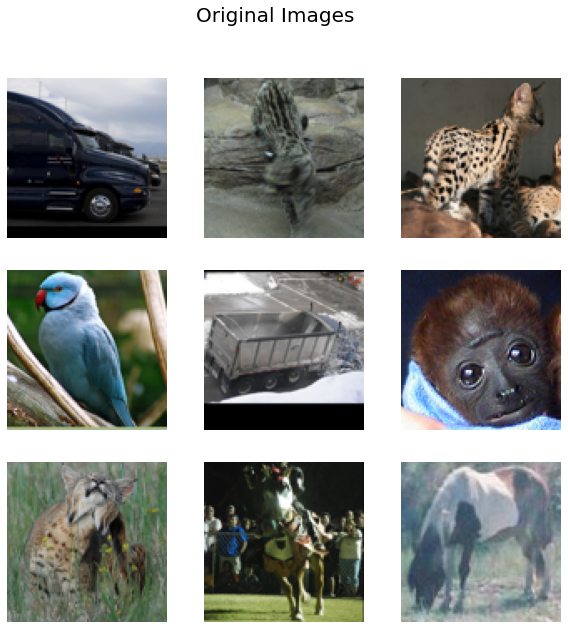

Input Shape:  (8000, 9216, 3)
Single Channel Shape:  (8000, 9216)
Loading Saved Basis...

Red channel:
Normalizing...
Before mean: 0.4472319483757019, std: 0.2605648934841156
After mean: -5.022239292884478e-06, std: 0.999998927116394
B loaded
Projecting...
BM.shape: (9216, 32)


/home/airscan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:67: ComplexWarning: Casting complex values to real discards the imaginary part



Green channel:
Normalizing...
Before mean: 0.4396430253982544, std: 0.25666144490242004
After mean: -2.1100408957863692e-06, std: 1.0000005960464478
B loaded
Projecting...
BM.shape: (9216, 32)

Blue channel:
Normalizing...
Before mean: 0.4049578309059143, std: 0.2699737846851349
After mean: -2.0963848328392487e-06, std: 0.9999997615814209
B loaded
Projecting...
BM.shape: (9216, 32)
Normalizing...
Normalizing...
Normalizing...


Current MSE:0.0190288033336401


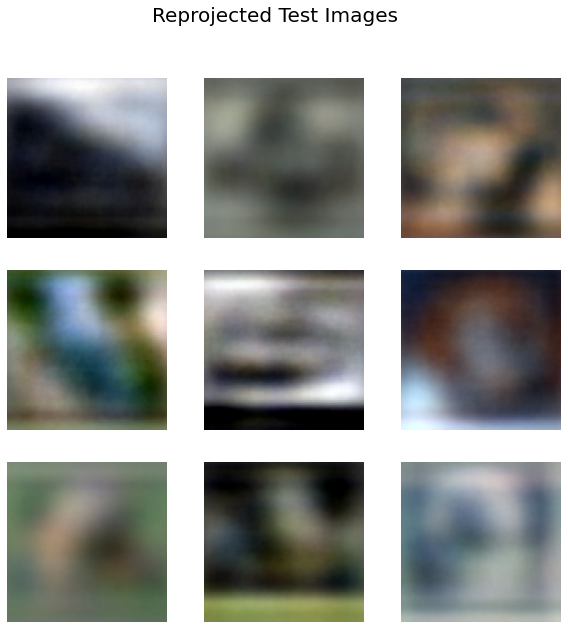

Input Shape:  (8000, 9216, 3)
Single Channel Shape:  (8000, 9216)
Loading Saved Basis...

Red channel:
Normalizing...
Before mean: 0.4472319483757019, std: 0.2605648934841156
After mean: -5.022239292884478e-06, std: 0.999998927116394
B loaded
Projecting...
BM.shape: (9216, 64)

Green channel:
Normalizing...
Before mean: 0.4396430253982544, std: 0.25666144490242004
After mean: -2.1100408957863692e-06, std: 1.0000005960464478
B loaded
Projecting...
BM.shape: (9216, 64)

Blue channel:
Normalizing...
Before mean: 0.4049578309059143, std: 0.2699737846851349
After mean: -2.0963848328392487e-06, std: 0.9999997615814209
B loaded
Projecting...
BM.shape: (9216, 64)
Normalizing...
Normalizing...
Normalizing...


Current MSE:0.01485409401357174


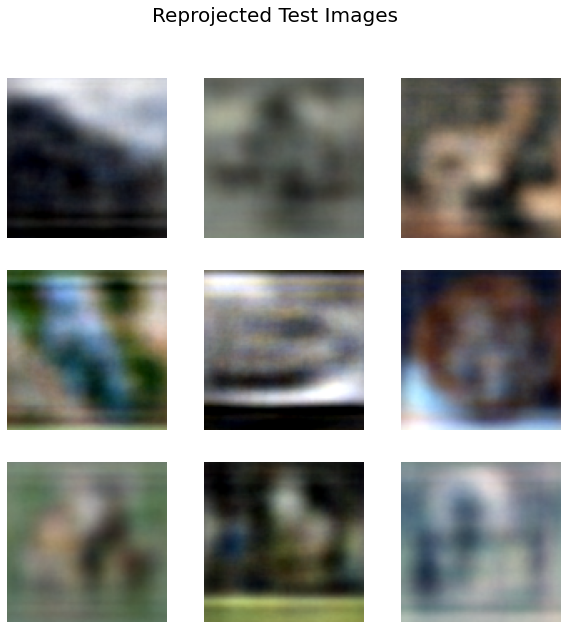

Input Shape:  (8000, 9216, 3)
Single Channel Shape:  (8000, 9216)
Loading Saved Basis...

Red channel:
Normalizing...
Before mean: 0.4472319483757019, std: 0.2605648934841156
After mean: -5.022239292884478e-06, std: 0.999998927116394
B loaded
Projecting...
BM.shape: (9216, 256)

Green channel:
Normalizing...
Before mean: 0.4396430253982544, std: 0.25666144490242004
After mean: -2.1100408957863692e-06, std: 1.0000005960464478
B loaded
Projecting...
BM.shape: (9216, 256)

Blue channel:
Normalizing...
Before mean: 0.4049578309059143, std: 0.2699737846851349
After mean: -2.0963848328392487e-06, std: 0.9999997615814209
B loaded
Projecting...
BM.shape: (9216, 256)
Normalizing...
Normalizing...
Normalizing...


Current MSE:0.008362088352441788


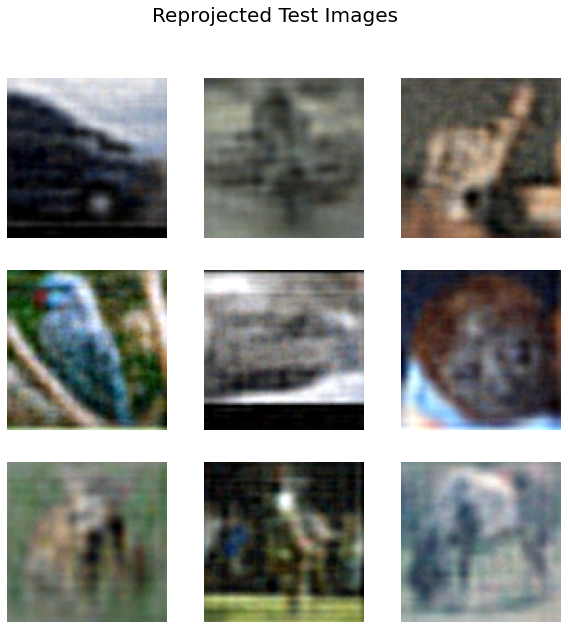

Input Shape:  (8000, 9216, 3)
Single Channel Shape:  (8000, 9216)
Loading Saved Basis...

Red channel:
Normalizing...
Before mean: 0.4472319483757019, std: 0.2605648934841156
After mean: -5.022239292884478e-06, std: 0.999998927116394
B loaded
Projecting...
BM.shape: (9216, 512)

Green channel:
Normalizing...
Before mean: 0.4396430253982544, std: 0.25666144490242004
After mean: -2.1100408957863692e-06, std: 1.0000005960464478
B loaded
Projecting...
BM.shape: (9216, 512)

Blue channel:
Normalizing...
Before mean: 0.4049578309059143, std: 0.2699737846851349
After mean: -2.0963848328392487e-06, std: 0.9999997615814209
B loaded
Projecting...
BM.shape: (9216, 512)
Normalizing...
Normalizing...
Normalizing...


Current MSE:0.005957480054348707


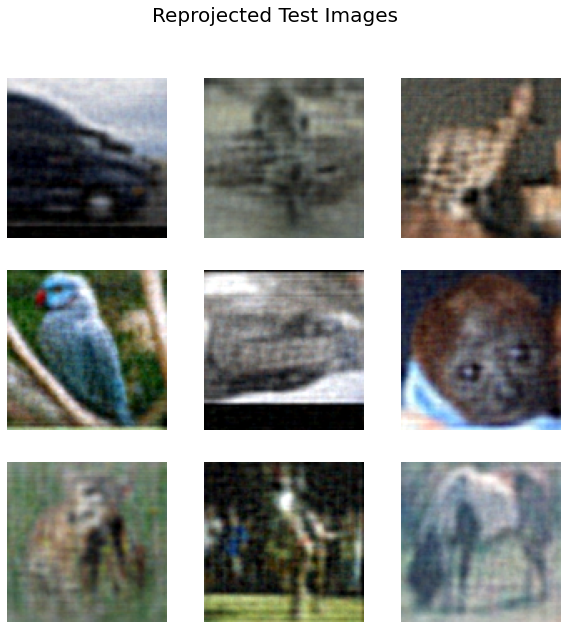

Input Shape:  (8000, 9216, 3)
Single Channel Shape:  (8000, 9216)
Loading Saved Basis...

Red channel:
Normalizing...
Before mean: 0.4472319483757019, std: 0.2605648934841156
After mean: -5.022239292884478e-06, std: 0.999998927116394
B loaded
Projecting...
BM.shape: (9216, 1028)

Green channel:
Normalizing...
Before mean: 0.4396430253982544, std: 0.25666144490242004
After mean: -2.1100408957863692e-06, std: 1.0000005960464478
B loaded
Projecting...
BM.shape: (9216, 1028)

Blue channel:
Normalizing...
Before mean: 0.4049578309059143, std: 0.2699737846851349
After mean: -2.0963848328392487e-06, std: 0.9999997615814209
B loaded
Projecting...
BM.shape: (9216, 1028)
Normalizing...
Normalizing...
Normalizing...


Current MSE:0.004002462141215801


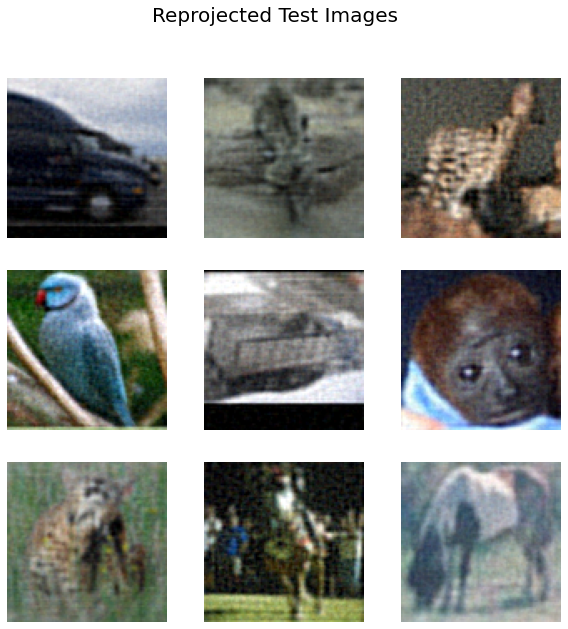

Input Shape:  (8000, 9216, 3)
Single Channel Shape:  (8000, 9216)
Loading Saved Basis...

Red channel:
Normalizing...
Before mean: 0.4472319483757019, std: 0.2605648934841156
After mean: -5.022239292884478e-06, std: 0.999998927116394
B loaded
Projecting...
BM.shape: (9216, 2046)

Green channel:
Normalizing...
Before mean: 0.4396430253982544, std: 0.25666144490242004
After mean: -2.1100408957863692e-06, std: 1.0000005960464478
B loaded
Projecting...
BM.shape: (9216, 2046)

Blue channel:
Normalizing...
Before mean: 0.4049578309059143, std: 0.2699737846851349
After mean: -2.0963848328392487e-06, std: 0.9999997615814209
B loaded
Projecting...
BM.shape: (9216, 2046)
Normalizing...
Normalizing...
Normalizing...


Current MSE:0.002421240322291851


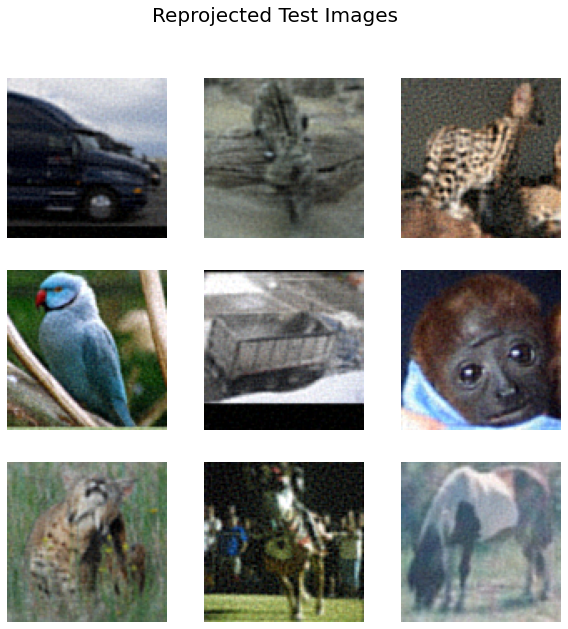

Input Shape:  (8000, 9216, 3)
Single Channel Shape:  (8000, 9216)
Loading Saved Basis...

Red channel:
Normalizing...
Before mean: 0.4472319483757019, std: 0.2605648934841156
After mean: -5.022239292884478e-06, std: 0.999998927116394
B loaded
Projecting...
BM.shape: (9216, 4098)

Green channel:
Normalizing...
Before mean: 0.4396430253982544, std: 0.25666144490242004
After mean: -2.1100408957863692e-06, std: 1.0000005960464478
B loaded
Projecting...
BM.shape: (9216, 4098)

Blue channel:
Normalizing...
Before mean: 0.4049578309059143, std: 0.2699737846851349
After mean: -2.0963848328392487e-06, std: 0.9999997615814209
B loaded
Projecting...
BM.shape: (9216, 4098)
Normalizing...
Normalizing...
Normalizing...


Current MSE:0.001124163274653256


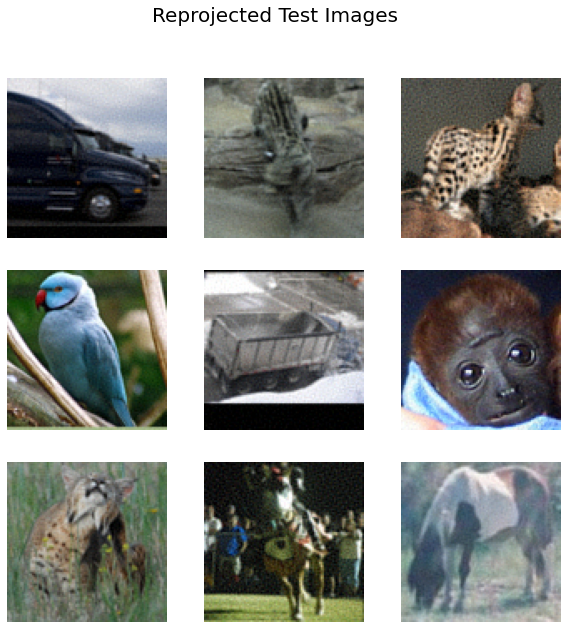

[0.0190288  0.01485409 0.00836209 0.00595748 0.00400246 0.00242124
 0.00112416]


In [9]:

plot_images(x_test, title='Original Images')


M_list = [32,64,256,512,1028,2046,4098]
mse_list=[]

for M in M_list:
    pca_data = STL10_PCA(x_test)
    pca_data.load_B('./basis.npz')
    pca_data.forward(M=M)
# 
    R = pca_data.Z2R(pca_data.Z)
    
    R_ch = np.reshape(R['Red'],(-1,96,96))
    G_ch = np.reshape(R['Green'],(-1,96,96))
    B_ch = np.reshape(R['Blue'],(-1,96,96))
    reprojected_X = np.stack([R_ch, G_ch, B_ch],axis=-1)
    
    current_mse = np.square(np.subtract(x_test,reprojected_X)).mean()
    mse_list = np.append(mse_list, current_mse)
    print('Current MSE:{0}'.format(current_mse))
    plot_images(reprojected_X, title='Reconstructed Images')
    
print(mse_list)

Plots the MSE vs z-dim for the experiment above.

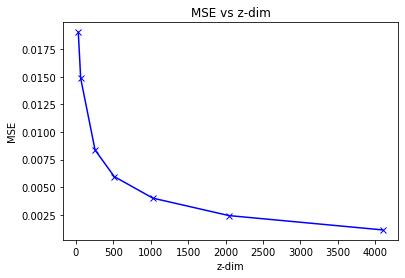

In [10]:
plt.plot(M_list,mse_list,'bx-')
plt.title('MSE vs z-dim')
plt.xlabel('z-dim')
plt.ylabel('MSE')
plt.show()

Based on the plot the smallest z-dim that yielded the lowest was when M = 4098. We will therefore make use of 4098-dim code for the GMM.

# Part 2. GMM

In [18]:
Z_R = pca_data.Z['Red']
Z_G = pca_data.Z['Green']
Z_B = pca_data.Z['Blue']

Z = np.stack([np.transpose(Z_R),np.transpose(Z_G),np.transpose(Z_B)], axis=-1)
X_train = np.reshape(Z, (Z.shape[0],-1))
print(X_train.shape)

(8000, 12294)


In [20]:
from scipy.stats import multivariate_normal

# n_dim = M_list[-1] 
n_dim = M*3
n_components = 10

mu_shape = (n_components,n_dim)
mu = np.random.normal(size=mu_shape)
sigma = [np.identity(n_dim) for _ in range(n_components)]
sigma_shape = np.array(sigma).shape
pi = np.random.randint(1,100, size=(n_components,1))
pi = pi/pi.sum()
# print('Initial mu:',mu)
# print('Initial sigma:',sigma)
# print('Initial pi:',pi)

n_loop = 100
nll = []

for loop in range(n_loop):
  rv = [multivariate_normal(mu[i],sigma[i]) for i in range(n_components)]
  g_val = np.array([rv[i].pdf(X_train) for i in range(n_components)])

  weighted_g_val = np.array([pi[i]*rv[i].pdf(X_train) for i in range(n_components)])
  weighted_g_val = np.log(weighted_g_val.sum(axis=0)).sum()
  nll.append(-weighted_g_val)

  p = np.repeat(pi, X_train.shape[0], axis=1)
  g_val_sum = np.multiply(p, g_val)
  g_val_sum = g_val_sum.sum(axis=0)

  g_val_sum = np.reshape(g_val_sum, (-1,g_val_sum.shape[0]))

  g_val_sum = np.repeat(g_val_sum, n_components, axis=0)

  r = np.multiply(p,g_val)
  r = np.divide(r, g_val_sum)

  Nk = r.sum(axis=1)
  Nk = np.repeat(Nk, n_components, axis=0)

  r = np.repeat(r, n_components, axis=0)
  x_t = [X_train.transpose() for _ in range(n_components)]
  x_t = np.concatenate(x_t,axis=0)
  mu = np.multiply(r, x_t).sum(axis=1)
  mu = np.divide(mu, Nk)
  mu = np.reshape(mu,[-1,1])

  x_t = x_t - mu
  x_tt = x_t
  x_t = np.multiply(x_t,r)
  x_t = np.reshape(x_t, (n_components, n_dim, -1))
  x_tt = np.reshape(x_tt, (n_components, n_dim, -1))

  sigma = [np.matmul(x_t[i], x_tt[i].transpose()) for i in range(x_t.shape[0])]

  N = np.reshape(Nk, (-1,1))
  N = np.repeat(N, n_components, axis=1)
  N = np.reshape(N, (n_components, n_components, -1))
  sigma = [np.divide(sigma[i], N[i]) for i in range(n_components)]

  Nk = Nk[::2]
  Nk = np.reshape(Nk, pi.shape)/X_train.shape[0]
  pi = np.reshape(Nk, pi.shape)

  mu = np.reshape(mu, mu_shape)
  sigma = np.reshape(np.array(sigma), sigma_shape)
  if loop == n_loop - 1:
    print('mu'.format(mu))
    print('sigma'.format(sigma))
    print('pi'.format(pi))
x = [loop for loop in range(n_loop)]
plt.plot(x,nll)
plt.title('Negative log-likelihood predicted by a GMM')
plt.xlabel('EM iteration')
plt.ylabel('NLL')
plt.show

MemoryError: Unable to allocate 11.3 GiB for an array with shape (10, 12294, 12294) and data type float64